In [1]:
%matplotlib inline
from __future__ import print_function, division, absolute_import
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
from pyuvwsim import (evaluate_baseline_uvw_ha_dec,
                      convert_enu_to_ecef)
from math import radians, degrees, pi, ceil, sin, asin, log10
import oskar

In [2]:
# Settings
lat = radians(34 + 4.0/60.0 + 43.497 / 3600.0)  # http://www.vla.nrao.edu/genpub/overview/
lon = -radians(107 + 37 / 60 + 3.819 / 3600.0)
dec = -radians(30) + (lat - radians(30))
ha_min = -0.0
ha_max = +0.0
dump_time = 10 # min
duration = ha_max - ha_min
num_times = 1 if duration == 0.0 else ((duration) * 60) // dump_time  # 1 sample every 10 min
freq_hz = 1000.0e6

In [3]:
# Load CASA VLA-C XYZ (ECEF) coordinates.
coords = np.loadtxt('../models/vla.c.cfg')
x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

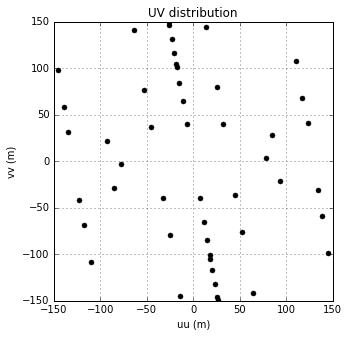

In [4]:
# Generate UV coordinates
uu, vv, ww = np.array([]), np.array([]), np.array([])
ha1_rad = (ha_min / 24) * (2 * pi)
ha2_rad = (ha_max / 24) * (2 * pi)
for i, ha in enumerate(np.linspace(ha1_rad, ha2_rad, num_times)):
    uu_, vv_, ww_ = evaluate_baseline_uvw_ha_dec(x, y, z, ha - lon, dec)
    uu, vv, ww = np.append(uu, uu_), np.append(vv, vv_), np.append(ww, ww_)

# uu = np.append(uu, [0.0])
# vv = np.append(vv, [0.0])
# ww = np.append(ww, [0.0])    
        
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(uu, vv, '.', color='k', ms=10.0, alpha=1.0)
ax.plot(-uu, -vv, '.', color='k', ms=10.0, alpha=1.0)
#ax.set_xlim(-60, -30)
#ax.set_ylim(20, 50)
ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)
ax.grid(True)
ax.set_xlabel('uu (m)')
ax.set_ylabel('vv (m)')
ax.set_title('UV distribution')
plt.show()

max: 3.37969
min: 0.04031
grid size = 650
psfrms = 0.0385406
0 2 50.307357 0.707107
1 6 62.777252 0.408248
2 10 78.338112 0.316228
3 20 97.756108 0.223607
4 26 121.987323 0.210663
5 42 152.224831 0.161484
6 60 189.957437 0.139443
7 80 237.042982 0.117260
8 112 295.799817 0.098619
9 146 369.120955 0.087178
10 186 460.616511 0.076790
11 234 574.791453 0.068376
12 294 717.267415 0.061413
13 370 895.059490 0.054189
14 440 1116.921631 0.049376
15 516 1393.777669 0.045450
16 606 1739.259171 0.041681
17 666 2170.376619 0.039669
18 690 2708.356952 0.038942
19 700 3379.688721 0.038651


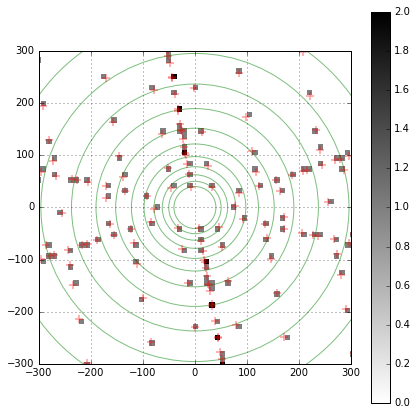

In [5]:
# Grid the uv data
oversampling = 2.4
r2d = (uu**2 + vv**2)**0.5
r3d = (uu**2 + vv**2 + ww**2)**0.5
uv_max = max(np.abs(uu).max(), np.abs(vv).max())
uv_min = min(np.abs(uu).min(), np.abs(vv).min())
print('max: %.5f' % (r2d.max() / 1e3))
print('min: %.5f' % (r2d.min() / 1e3))

b_max = r2d.max() * 2.0
dish_d = 25.0  # m
grid_size = int(ceil(oversampling * (b_max / dish_d)))
if grid_size % 2 == 1:
    grid_size += 1
cell = b_max / grid_size
h, xedges, yedges = np.histogram2d(np.hstack((uu, -uu)), np.hstack((vv, -vv)), (grid_size, grid_size))
print('grid size =', grid_size)

wavelength = 299792458.0 / freq_hz
cell_lm = 1.0 / (grid_size * (cell / wavelength))
lm_max = (grid_size * sin(cell_lm)) / 2.0
fov = degrees(asin(lm_max)) * 2.0

# FIXME(BM) interface for cell size?
imager = oskar.imager.Imager('Single')
imager.set_size(grid_size)
imager.set_grid_kernel('Pillbox', 1, 1)
imager.set_fov(fov)
uv_grid = np.zeros((grid_size, grid_size), dtype='c8')
imager.update_plane(uu / wavelength, vv / wavelength,
                    np.zeros_like(uu), 
                    np.ones_like(uu, dtype='c8'), 
                    np.ones_like(uu), uv_grid, 0.0)
imager.update_plane(-uu / wavelength, -vv / wavelength,
                    np.zeros_like(uu), 
                    np.ones_like(uu, dtype='c8'), 
                    np.ones_like(uu), uv_grid, 0.0)

psfrms = np.sqrt(np.sum(uv_grid.real**2)) / (uu.shape[0] * 2.0)
print('psfrms = %.7f' % psfrms)

# Grid pixel coordinates.
centre = grid_size // 2

# Get grid pixel x, y  and then r so can filter on r
x_ = np.arange(-centre, centre) * cell
gx, gy = np.meshgrid(-x_, x_)
gr = (gx**2 + gy**2)**0.5


# Radial psfrms
res_n = 20  # Number of radial points
res_bmin = None  # value in m, or None
res_bmax = None  # value in m, or None
#res_bmin = 40.4426  # value in m, or None
#res_bmax = 3379.73  # value in m, or None
b0 = r2d.min() if not res_bmin else res_bmin
b1 = r2d.max() if not res_bmax else res_bmax
r_bins = np.logspace(log10(b0), log10(b1), res_n + 1)

psfrms_r = np.zeros(res_n)
for i in range(res_n):
    # grid_idx = np.where(np.logical_and(gr > r_bins[i], gr <= r_bins[i + 1]))
    # uv_idx = np.where(np.logical_and(r2d > r_bins[i], r2d <= r_bins[i + 1]))[0]                    
    grid_idx = np.where(gr <= r_bins[i + 1])
    pixels = uv_grid[grid_idx]
    uv_idx = np.where(r2d <= r_bins[i + 1])[0]                    
    uv_count = uv_idx.shape[0] * 2
    psfrms_r[i] = 1.0 if uv_count == 0 else np.sqrt(np.sum(pixels.real**2)) / uv_count
    print('%i %i %f %f' % (i, uv_count, r_bins[i + 1], psfrms_r[i]))
        
# Plotting
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
for i in range(res_n + 1):
    c = plt.Circle((0.0, 0.0), r_bins[i], fill=False, color='g',
                   linestyle='-', linewidth=1, alpha=0.5)
    ax.add_artist(c)  
    #uv_grid[np.where(np.logical_and(gr > r_bins[1], gr <= r_bins[2]))] = 5.0 + 0j
extent = np.array([centre + 0.5, -centre + 0.5,
                   -centre - 0.5, centre - 0.5])
extent *= cell
im = ax.imshow(uv_grid.real, interpolation='nearest', cmap='gray_r', 
               origin='lower', extent=extent)
ax.figure.colorbar(im, ax=ax)
ax.plot(uu, vv, '+', ms=8.0, color='r', alpha=0.4, mew=1.5)
ax.plot(-uu, -vv, '+', ms=8.0, color='r', alpha=0.4, mew=1.5)
#ax.imshow(gr, interpolation='nearest', origin='lower', extent=extent, cmap='gray')

z = 300 
ax.set_xlim(-z, z)
ax.set_ylim(-z, z)
ax.grid()
plt.show()


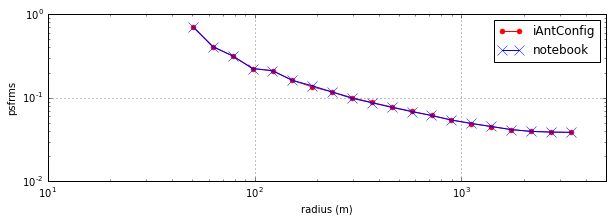

In [8]:
# Results from iAntConfig (http://public.ska.ac.za/software/iantconfig)
data = np.loadtxt('/Users/bmort/Desktop/vla_c_snapshot.20x2.txt', skiprows=1)
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(111)
ax.plot(data[:, 0], data[:, 1], 'r.-', ms=10, label='iAntConfig')
ax.plot(r_bins[1:], psfrms_r, 'bx-', ms=10, label='notebook')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 5000)
ax.grid(True)
ax.set_xlabel('radius (m)')
ax.set_ylabel('psfrms')
ax.legend()
plt.show()